In [4]:
#importing google drive to get access to the datasets
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [40]:

# At first, we import all the necessary python packages

import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

#we create two lists,one for our images data and the other for their labels.

data = []
labels = []

#path to the dataset containing normal images in google drive
path = "/content/drive/My Drive/keras-covid-19/dataset/normal"

# looping over the images of normal-dataset
for file in os.listdir("/content/drive/My Drive/keras-covid-19/dataset/normal"):
	# setting label as '0' for normal images
	label = 0

	# loading the image,converting to rgb format and resizing to
	# 224x224 pixels while ignoring aspect ratio

	image = cv2.imread(path + '/' + file)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# updating the data and labels lists, respectively
	data.append(image)
	labels.append(label)

#path to the dataset containing covid-19 images in google drive
path1 = "/content/drive/My Drive/keras-covid-19/dataset/covid"

# looping over the images of covid-19-dataset
for file in os.listdir("/content/drive/My Drive/keras-covid-19/dataset/covid"):
	# setting label as '1' for covid images
	label = 1

  # loading the image,converting to rgb format and resizing to
	# 224x224 pixels while ignoring aspect ratio

	image = cv2.imread(path1+ '/' + file)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)


# converting the labels to one-hot-encode format
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

#viewing the labels as one-hot-encoded vectors
print(labels)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [0]:
# we initialize the learning rate and batch size for our training
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [0]:
#Importing necessary libraries of tensorflow and scikit-learn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths

In [0]:
# partitioning the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)

# initialize the training data augmentation object tp create an augmented dataset of images rotated by 15 degrees random either anticlockwise or clockwise
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [0]:
# We use a deep-convolutional-network structure called VGG-16(VIRTUAL GEOMETRY GROUP:16)
# loading the VGG16 network, ensuring the head FC layer sets are left off

baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# constructing the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)   #applying a pooling  layer
headModel = Flatten(name="flatten")(headModel)              #applying a flattened layer
headModel = Dense(64, activation="relu")(headModel)         #applying a dense layer with ReLU(rectified linear unit) as the activation function
headModel = Dropout(0.5)(headModel)                         #applying a dropout layer with probabilty of 0.5
headModel = Dense(2, activation="softmax")(headModel)       #Finally outputing the final layer with the softmax activation function


# place the head FC(Fully connected) model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# looping over all layers in the base model and freezing them so they will not be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


In [45]:
# We compile our built model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)      #using adam's optimizer for the loss function
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),     #finalizing the batch size,epochs-steps.-Batch size(BS)=8
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
4/4 [==============================] - 1s 138ms/step - loss: 0.8232 - accuracy: 0.5312 - val_loss: 0.6569 - val_accuracy: 0.6154
Epoch 2/25
4/4 [==============================] - 0s 113ms/step - loss: 0.8796 - accuracy: 0.4828 - val_loss: 0.6594 - val_accuracy: 0.4615
Epoch 3/25
4/4 [==============================] - 0s 100ms/step - loss: 0.8414 - accuracy: 0.5517 - val_loss: 0.6631 - val_accuracy: 0.4615
Epoch 4/25
4/4 [==============================] - 0s 102ms/step - loss: 0.7930 - accuracy: 0.5172 - val_loss: 0.6586 - val_accuracy: 0.4615
Epoch 5/25
4/4 [==============================] - 0s 94ms/step - loss: 0.7115 - accuracy: 0.5517 - val_loss: 0.6441 - val_accuracy: 0.4615
Epoch 6/25
4/4 [==============================] - 0s 103ms/step - loss: 0.7201 - accuracy: 0.6562 - val_loss: 0.6158 - val_accuracy: 0.8462
Epoch 7/25
4/4 [==============================] - 0s 106ms/step - loss: 0.7084 - accuracy: 0.5172 - val_loss: 0

In [46]:
#making predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# we have to find the index of the label with corresponding largest predicted probability for each image in the testing data
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...


In [47]:
# Finally  we compute the confusion matrix and analyse the accuracy, recall, f1-score,macro average ,weighted average,sensitivity, and specificity.
print(classification_report(testY.argmax(axis=1), predIdxs))
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

[[5 1]
 [0 7]]
acc: 0.9231
sensitivity: 0.8333
specificity: 1.0000


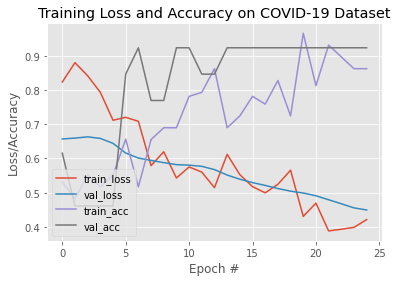

In [48]:
#Achieved an accuracy of 92% on the testing data set and other validation-measures are as shown in the report above
#At last we are plotting a graph of the training loss an accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [0]:
####################################    THANK YOU     #################################################